In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from numpy import pi
from copy import copy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from scipy.stats import poisson
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [28]:
# @title Basic plots of subject estimate average by task conditions

# circular statistics utils
# -------------------
def get_cartesian_to_deg(x: np.ndarray, y: np.ndarray, signed: bool) -> np.ndarray:
    """convert cartesian coordinates to
    angles in degree
    Args:
        x (np.ndarray): x coordinate
        y (np.ndarray): y coordinate
        signed (boolean): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_cartesian_to_deg
            x = np.array([1, 0, -1, 0])
            y = np.array([0, 1, 0, -1])
            degree = get_cartesian_to_deg(x,y,False)
            # Out: array([  0.,  90., 180., 270.])
    Returns:
        np.ndarray: angles in degree
    """
    # convert to radian (ignoring divide by 0 warning)
    with np.errstate(divide="ignore"):
        degree = np.arctan(y / x)

    # convert to degree and adjust based
    # on quadrant
    for ix in range(len(x)):
        if (x[ix] >= 0) and (y[ix] >= 0):
            degree[ix] = degree[ix] * 180 / np.pi
        elif (x[ix] == 0) and (y[ix] == 0):
            degree[ix] = 0
        elif x[ix] < 0:
            degree[ix] = degree[ix] * 180 / np.pi + 180
        elif (x[ix] >= 0) and (y[ix] < 0):
            degree[ix] = degree[ix] * 180 / np.pi + 360

    # if needed, convert signed to unsigned
    if not signed:
        degree[degree < 0] = degree[degree < 0] + 360
    return degree


def get_deg_to_rad(deg: np.array, signed: bool):
    """convert angles in degree to radian
    Args:
        deg (np.array): angles in degree
        signed (bool): True (signed) or False (unsigned)
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_deg_to_rad
            radians = get_deg_to_rad(np.array([0, 90, 180, 270], True)
            Out: array([ 0., 1.57079633, 3.14159265, -1.57079633])
    Returns:
        np.ndarray: angles in radian
    """
    # get unsigned radians (1:2*pi)
    rad = (deg / 360) * 2 * pi

    # get signed radians(-pi:pi)
    if signed:
        rad[deg > 180] = (deg[deg > 180] - 360) * (2 * pi / 360)
    return rad


def get_polar_to_cartesian(angle: np.ndarray, radius: float, type: str) -> dict:
    """convert angle in degree or radian to cartesian coordinates
    Args:
        angle (np.ndarray): angles in degree or radian
        radius (float): radius
        type (str): "polar" or "radian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_polar_to_cartesian
            degree = np.array([0, 90, 180, 270])
            cartesian = get_polar_to_cartesian(degree, 1, "polar")
            cartesian.keys()

            # Out: dict_keys(['deg', 'rad', 'cart'])

            cartesian["cart"]

            # Out: array([[ 1.,  0.],
            #            [ 0.,  1.],
            #            [-1.,  0.],
            #            [-0., -1.]])
    Returns:
        dict: _description_
    """
    # convert to radian if needed
    theta = dict()
    if type == "polar":
        theta["deg"] = angle
        theta["rad"] = angle * np.pi / 180
    elif type == "radian":
        theta["deg"] = get_deg_to_rad(angle, False)
        theta["rad"] = angle

    # convert to cartesian coordinates
    x = radius * np.cos(theta["rad"])
    y = radius * np.sin(theta["rad"])

    # round to 10e-4
    x = np.round(x, 4)
    y = np.round(y, 4)

    # reshape as (N angles x 2 coord)
    theta["cart"] = np.vstack([x, y]).T
    return theta


def get_circ_weighted_mean_std(angle: np.ndarray, proba: np.ndarray, type: str) -> dict:
    """calculate circular data statistics
    Args:
        angle (np.ndarray): angles in degree or cartesian coordinates
        proba (np.ndarray): each angle's probability of occurrence
        type (str): "polar" or "cartesian"
    Usage:
        .. code-block:: python
            import numpy as np
            from bsfit.nodes.cirpy.utils import get_circ_weighted_mean_std
            degree = np.array([358, 0, 2, 88, 90, 92])
            proba = np.array([1, 1, 1, 1, 1, 1])/6
            output = get_circ_weighted_mean_std(degree, proba, "polar")
            output.keys()
            # Out: dict_keys(['coord_all', 'deg_all', 'coord_mean', 'deg_mean',
            #               'deg_all_for_std', 'deg_mean_for_std', 'deg_var',
            #               'deg_std', 'deg_sem'])
            output["deg_mean"]
            # Out: array([45.])
            output["deg_std"]
            # array([45.02961988])
    Returns:
        (dict): angle summary statistics (mean, std, var, sem)

    Raises:
        ValueError: type is not "polar" or "cartesian"
    """

    angle = angle.copy()

    # if polar, convert to cartesian
    if type == "polar":
        radius = 1
        coord = get_polar_to_cartesian(angle, radius=radius, type="polar")
    elif type == "cartesian":
        coord = angle
    else:
        raise ValueError(""" "type" can either be "polar" or "cartesian" value """)

    # store angles
    data = dict()
    data["coord_all"] = coord["cart"]
    data["deg_all"] = coord["deg"]

    # calculate mean
    # ..............
    proba_for_mean = np.tile(proba[:, None], 2)
    data["coord_mean"] = np.sum(proba_for_mean * data["coord_all"], 0)
    data["coord_mean"] = data["coord_mean"][:, None]
    data["deg_mean"] = get_cartesian_to_deg(
        data["coord_mean"][0],
        data["coord_mean"][1],
        signed=False,
    )

    # calculate std
    # ..............
    n_data = len(data["deg_all"])
    data["deg_all_for_std"] = data["deg_all"]
    data["deg_mean_for_std"] = np.tile(data["deg_mean"], n_data)

    # apply corrections
    # when 0 <= mean <= 180
    if data["deg_mean"] + 180 <= 360:
        for ix in range(n_data):
            if data["deg_all"][ix] >= data["deg_mean"] + 180:
                data["deg_all_for_std"][ix] = data["deg_all"][ix] - 360
    else:
        # when 180 <= mean <= 360
        for ix in range(n_data):
            if data["deg_all"][ix] <= data["deg_mean"] - 180:
                data["deg_mean_for_std"][ix] = data["deg_mean"] - 360

    # calculate variance, standard deviation and
    # standard error to the mean
    data["deg_var"] = np.array(
        [sum(proba * (data["deg_all_for_std"] - data["deg_mean_for_std"]) ** 2)]
    )
    data["deg_std"] = np.sqrt(data["deg_var"])
    data["deg_sem"] = data["deg_std"] / np.sqrt(n_data)
    return data


def get_signed_angle(origin: np.ndarray, destination: np.ndarray, type: str):
    """get the signed angle difference between origin and destination angles
    Args:
        origin (np.ndarray): origin angle
        destination (np.ndarray): destination angle
        type (str): angle type ("polar", "radian", "cartesian")
    Usage:
        .. code-block:: python
            angle = get_signed_angle(90, 45, 'polar')

            # Out: array([45.])

            angle = get_signed_angle(90, 45, 'radian')
            # Out: array([58.3103779])
            origin = np.array([[0, 1]])
            destination = np.array([[1, 0]])
            angle = get_signed_angle(origin, destination, "cartesian")

            # Out: array([90.])
    Returns:
        (np.ndarray): signed angle differences
    """

    # convert to cartesian coordinates
    if type == "polar" or type == "radian":
        origin_dict = get_polar_to_cartesian(origin, radius=1, type=type)
        destination_dict = get_polar_to_cartesian(destination, radius=1, type=type)
    elif type == "cartesian":
        origin_dict = dict()
        destination_dict = dict()
        origin_dict["cart"] = origin
        destination_dict["cart"] = destination

    # get coordinates
    xV1 = origin_dict["cart"][:, 0]
    yV1 = origin_dict["cart"][:, 1]
    xV2 = destination_dict["cart"][:, 0]
    yV2 = destination_dict["cart"][:, 1]

    # Calculate the angle separating the
    # two vectors in degrees
    angle = -(180 / np.pi) * np.arctan2(xV1 * yV2 - yV1 * xV2, xV1 * xV2 + yV1 * yV2)
    return angle


def get_combination_set(database: np.ndarray):
    """get the set of row combinations

    Args:
        database (np.ndarray): an N-D array

    Returns:
        (np.ndarray, np.ndarray, np.ndarray): `combs` is the set
        of combinations, `b` are the row indices for each combination
        in database, `c` are the rows indices for each combination in
        combs.
    """
    combs, ia, ic = np.unique(
        database,
        return_index=True,
        return_inverse=True,
        axis=0,
    )
    return (combs, ia, ic)


def get_data_stats(data: pd.Series, output: dict):
    """calculate data statistics

    Args:
        data (pd.Series): stimulus feature estimates
        output (dict): ::

            'PestimateGivenModel': estimate probabilities
            'map': max-a-posteriori percepts
            'conditions': task conditions

    Returns:
        (dict): returns data mean and std to output
    """
    # get conditions
    cond = output["conditions"]

    # initialise statistics
    data_mean = []
    data_std = []

    # get set of conditions
    cond_set, ix, _ = get_combination_set(cond)

    # record stats by condition
    for c_i in range(len(cond_set)):
        # find condition's instances
        loc_1 = cond[:, 0] == cond_set[c_i, 0]
        loc_2 = cond[:, 1] == cond_set[c_i, 1]
        loc_3 = cond[:, 2] == cond_set[c_i, 2]

        # get associated data
        data_c_i = data.values[loc_1 & loc_2 & loc_3]

        # set each instance with equal probability
        trial_proba = np.tile(1 / len(data_c_i), len(data_c_i))

        # get statistics
        stats = get_circ_weighted_mean_std(
            data_c_i,
            trial_proba,
            type="polar",
        )

        # record statistics
        data_mean.append(stats["deg_mean"])
        data_std.append(stats["deg_std"])

    # record statistics
    output["data_mean"] = np.array(data_mean)
    output["data_std"] = np.array(data_std)

    # record their condition
    output["conditions"] = cond_set
    return output


# Visualization utils
# -------------------
def plot_mean(
    data_mean: np.ndarray,
    data_std: np.ndarray,
    condition: np.ndarray,
    prior_mode: float,
    centering: bool,
):
    """plot data and prediction mean and std
    for three conditions (x-axis, colors and panels)
    Args:
        data_mean (np.ndarray): data mean by condition
        data_std (np.ndarray): data std by condition
        prediction_mean (np.ndarray): prediction mean by condition
        prediction_std (np.ndarray): prediction std by condition
        condition (np.ndarray): associated conditions
        prior_mode (float): the mode of the prior
        centering (bool): center x-axis or not
    Returns:
        _type_: _description_
    """
    # get condition levels
    levels_1 = np.flip(np.unique(condition[:, 0]))
    levels_2 = np.flip(np.unique(condition[:, 1]))  # sort in decreasing order
    levels_3 = np.unique(condition[:, 2])

    # set x_tick
    x_tick_centered = get_signed_angle(levels_1, prior_mode, "polar")
    x_tick_centered[x_tick_centered == -180] = 180
    i_sort = np.argsort(x_tick_centered)
    x_tick_centered = x_tick_centered[i_sort]
    y_tick_centered = x_tick_centered

    # set colors
    levels_2_color = [
        [0.5, 0, 0],
        [1, 0.2, 0],
        [1, 0.6, 0],
        [0.75, 0.75, 0],
    ]

    plt.figure(figsize=(10, 3))

    # loop over conditions and plot data
    # and prediction stats
    for level2_ix in range(len(levels_2)):
        # set condition 2 in column panels
        plt.subplot(1, len(levels_2), level2_ix + 1)

        # set condition 3 within panels
        for level1_ix in range(len(levels_1)):
            # find condition's instances
            loc_lev1 = condition[:, 0] == levels_1[level1_ix]
            loc_lev2 = condition[:, 1] == levels_2[level2_ix]
            loc_condition = loc_lev2 & loc_lev1

            # center to prior mode
            x_centered = condition[:, 2][loc_condition]
            if centering:
                x_centered = np.round(
                    get_signed_angle(
                        x_centered,
                        prior_mode,
                        "polar",
                    )
                )

            x_centered[x_centered == -180] = 180

            # make 2-D array
            x_centered = x_centered[:, None]

            # sort data stats
            y_data_centered = data_mean[loc_condition]
            y_data_std_centered = data_std[loc_condition]

            # sort all
            i_sort = np.argsort(x_centered.squeeze())
            x_centered = x_centered[i_sort]
            y_data_centered = y_data_centered[i_sort]
            y_data_std_centered = y_data_std_centered[i_sort]

            # To plot estimates mean against circular stimulus
            # feature on a linear space, the raw stimulus feature and
            # estimates mean are normalized to vectorial angles from
            # the prior mode and x and y axes are centered at zero
            # (normalized prior mode) via a circular shift. Rotation
            # angles were then labelled according to their raw values
            # on the circle (e.g., 0, is labelled 225). A mean estimate
            # of 33 degree was calculated for 55 degree which is very far
            # from stimulus feature on the linear space but actually close
            # to stimulus feature on the circular space. We got rid of
            # this visual artifact by expressing both 55 and 33 as the
            # counterclockwise distance to prior mode (e.g., for a prior
            # mode 225 55 becomes 190 instead of 170 and 33 becomes 168).
            # Note that the maximum vectorial angle is >180.
            if (level2_ix == 3) & (not 180 in x_centered):
                # move point at -170? distance to prior at 190? (positive
                # side) and convert values at x=-170? to positive distance
                # relative to prior to improve visualization
                posNeg170 = x_centered == -170
                x_centered[posNeg170] = prior_mode - 170 + 360 - prior_mode
                x_centered[x_centered == 180] = -180
                y_data_centered[posNeg170] = (
                    prior_mode - abs(y_data_centered[posNeg170]) + 360 - prior_mode
                )

                # sort x-axis
                i_sort = np.argsort(x_centered)
                x_centered = x_centered[i_sort]

                # sort y-axis
                y_data_centered = y_data_centered[i_sort]

                # set ticks
                x_tick_centered = x_centered

            # plot data stats
            plt.errorbar(
                x_centered.squeeze(),
                y_data_centered.squeeze(),
                yerr=y_data_std_centered.squeeze(),
                marker="o",
                markersize=7,
                markeredgecolor="w",
                linestyle="None",
                linewidth=1,
                color=levels_2_color[level1_ix],
                ecolor=levels_2_color[level1_ix],
            )
            plt.ylim([-0, 360])
            plt.hlines(prior_mode, -180, 180, linestyle=":")
            plt.xticks([-160, -80, 0, 80, 160], [-160, -80, 0, 80, 160])
            plt.yticks([67, 147, 227, 307, 387], [-160, -80, 0, 80, 160])
            plt.xlabel(
                "Motion direction distance"
                "\n"
                "relative to the prior mean"
                "\n"
                "(deg)"
            )
            if level2_ix == 0:
                plt.ylabel(
                    "Mean estimates distance"
                    "\n"
                    "relative to the prior mean"
                    "\n"
                    "(deg)"
                )
        plt.title(f"{int(levels_2[level2_ix]*100)}% coherence", fontsize=12)
    plt.show()
    return None

In [29]:
# @title Figure settings
rcParams["figure.figsize"] = [20, 4]
rcParams["font.size"] = 11
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["figure.autolayout"] = True

In [63]:
# @title Data retrieval

url = "https://github.com/steevelaquitaine/projInference/raw/gh-pages/data/csv/data01_direction4priors.csv"
try:
    RequestAPI = requests.get(url)
except requests.ConnectionError:
    print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
else:
    if RequestAPI.status_code != requests.codes.ok:
        print("Failed to download data. Please contact steeve.laquitaine@epfl.ch")
    else:
        with open("data01_direction4priors.csv", "wb") as fid:
            fid.write(RequestAPI.content)

In [86]:
# @title Data loading
data = pd.read_csv("data01_direction4priors.csv")
data = pd.DataFrame(data)
data.head()

,trial_index,trial_time,response_arrow_start_angle,motion_direction,motion_coherence,estimate_x,estimate_y,reaction_time,raw_response_time,prior_std,prior_mean,subject_id,experiment_name,experiment_id,session_id,run_id
0,1,0.000000,NaN,225,0.12,-1.749685,-1.785666,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
1,2,2.730730,NaN,225,0.12,-1.819693,-1.714269,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
2,3,4.913950,NaN,235,0.06,-1.562674,-1.951422,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
3,4,6.997296,NaN,225,0.06,-1.601388,-1.919781,NaN,NaN,10,225,1,data01_direction4priors,11,1,1
4,5,9.097130,NaN,215,0.24,-1.639461,-1.887371,NaN,NaN,10,225,1,data01_direction4priors,11,1,1


In [87]:
estimate_direction = np.round(
    get_cartesian_to_deg(data["estimate_x"], data["estimate_y"], False)
)
data["estimate_direction"] = estimate_direction

In [88]:
# Calculate circular distances between past estimates and current motion directions
circular_distance = get_signed_angle(
    data["estimate_direction"].shift(1), data["motion_direction"], type="polar"
)
data["circular_distance"] = circular_distance

In [89]:
# calculate circular error
error = get_signed_angle(
    data["motion_direction"], data["estimate_direction"], type="polar"
)
data["error"] = error
data["error"] = data["error"].abs()

In [72]:
# Group the data by prior_std, and then coherence
grouped = data.groupby(["motion_coherence"])
grouped.agg({"error": ["mean"]})

,error
,mean
motion_coherence,
0.06,39.144672
0.12,26.725496
0.24,14.819311


In [70]:
# Group the data by prior_std, and then coherence
grouped = data.groupby(["prior_std"])
grouped.agg({"error": ["mean"]})

,error
,mean
prior_std,
10,17.452079
20,22.883954
40,32.191456
80,40.583491


In [71]:
# Group the data by prior_std, and then coherence
grouped = data.groupby(["prior_std", "motion_coherence"])
grouped.agg({"error": ["mean"]})

error
                                 mean
prior_std motion_coherence           
10        0.06              19.788198
          0.12              16.963837
          0.24              11.732978
20        0.06              26.778413
          0.12              21.569381
          0.24              12.752089
40        0.06              40.370306
          0.12              28.018729
          0.24              15.216485
80        0.06              54.082633
          0.12              33.427678
          0.24              16.943158

In [90]:
# Drop the first row with NaN value in circular distance
data = data.dropna(subset=["circular_distance", "error"])

In [ ]:
# How do we train the best linear model to predict the error?
# Obviously we would need to maybe split by subject, coherence, and prior_std. But these are precisely the things that decide the error!
# See if the previous pattern of coherences or errors! Can predict the error!
# We would need to fit a linear-nonlinear model?

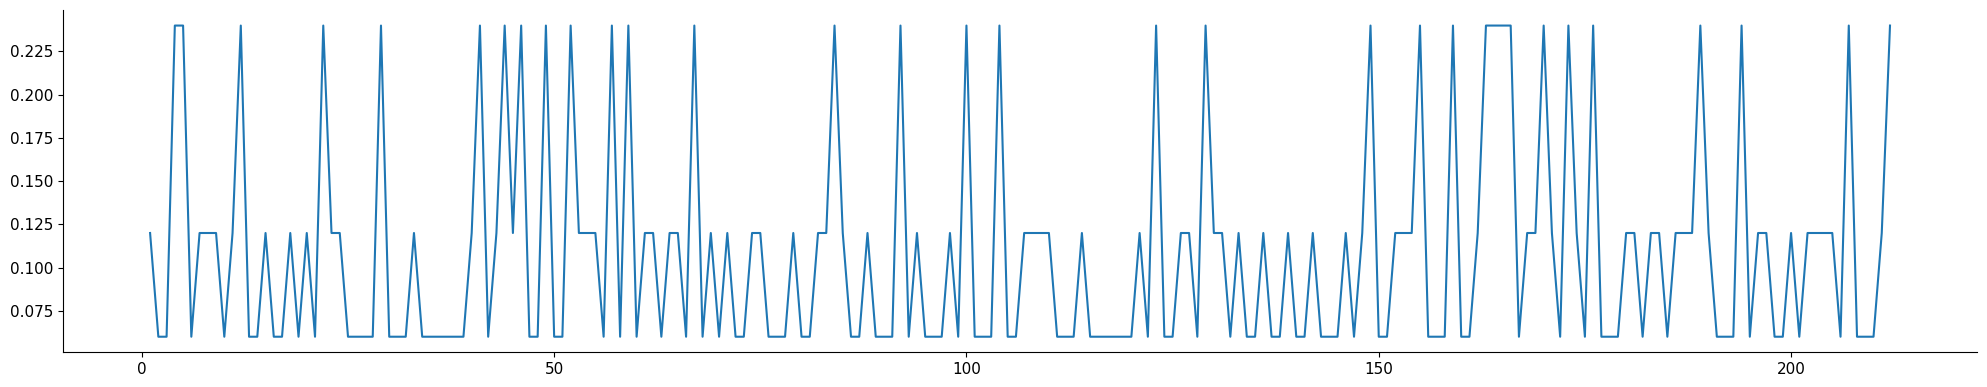

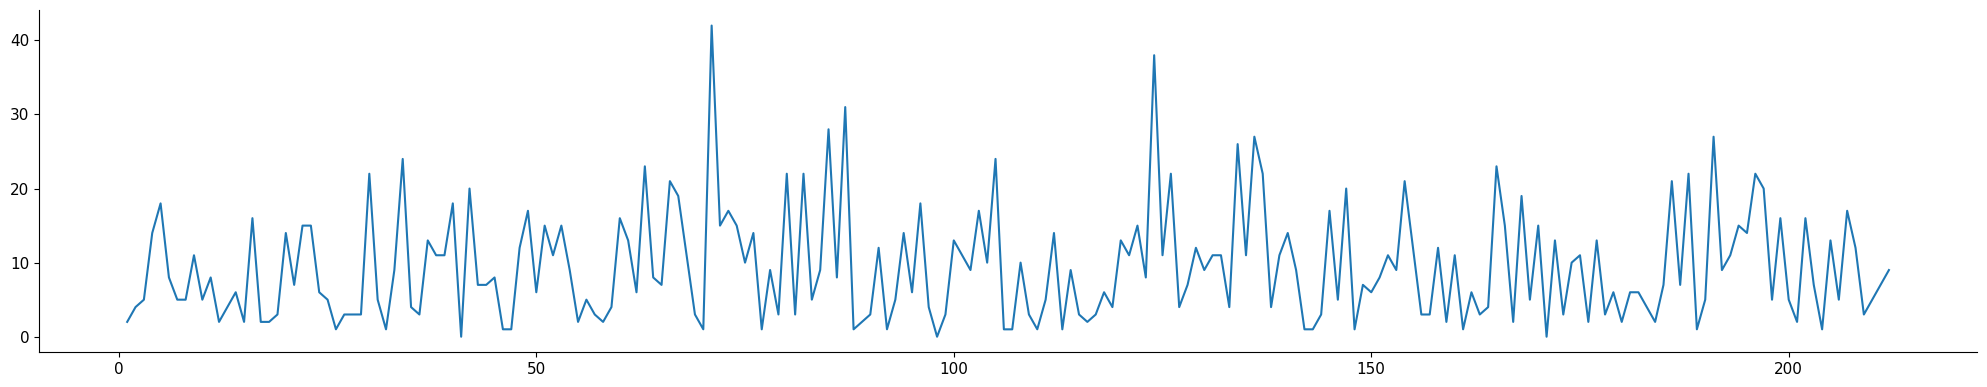

In [110]:
# Plot the time_varying error for each subject for specific prior_std and coherence
grouped = data.groupby(["subject_id", "session_id", "prior_std"])

# Subject_id=1, session_id=1, prior_std=10
subject_1 = grouped.get_group((1, 1, 10))

# Plot the error for this group
plt.plot(subject_1["motion_coherence"])
plt.show()
plt.plot(subject_1["error"])
plt.show()

In [ ]:
# Coherence values
# Linear-gaussian
# use Von Mises

In [101]:
len(subject_1)

212

In [104]:
def concatenate_sessions(data, subject_id, prior_std):
    # Filter the data for the specific subject_id and prior_std
    filtered_data = data[
        (data["subject_id"] == subject_id) & (data["prior_std"] == prior_std)
    ]

    # Group by session_id
    grouped = filtered_data.groupby("session_id")

    # List to store processed sessions
    processed_sessions = []

    for session_id, session_data in grouped:
        # Sort the session data by trial_index to ensure correct order
        session_data = session_data.sort_values("trial_index")

        processed_sessions.append(session_data)

    # Concatenate all processed sessions
    concatenated_data = pd.concat(processed_sessions, ignore_index=True)

    return concatenated_data

In [106]:
subject_1 = concatenate_sessions(data, 1, 10)

In [107]:
# Assuming 'data' is your DataFrame
# We'll create a function to get the previous n trial coherences
def get_previous_coherences(df, n):
    return np.array([df["motion_coherence"].shift(i) for i in range(1, n + 1)]).T


# Let's use the last 5 trials
n_previous = 5

# Prepare the features (X) and target (y)
X = get_previous_coherences(subject_1, n_previous)
y = subject_1["error"].values

# Remove rows with NaN values (first n_previous rows)
X = X[n_previous:]
y = y[n_previous:]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [108]:
# Linear part
model = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Poisson())
results = model.fit()

# Print the summary of the model
print(results.summary())

# Predict on the test set
y_pred = results.predict(sm.add_constant(X_test))

# Nonlinear part (exponential function)
y_pred_nonlinear = np.exp(y_pred)

# Poisson part
y_pred_poisson = poisson.rvs(y_pred_nonlinear)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_poisson)
print(f"Mean Squared Error: {mse}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1377
Model:                            GLM   Df Residuals:                     1371
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8365.1
Date:                Fri, 12 Jul 2024   Deviance:                       11528.
Time:                        17:43:07   Pearson chi2:                 1.65e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08057
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3601      0.033     71.558      0.0

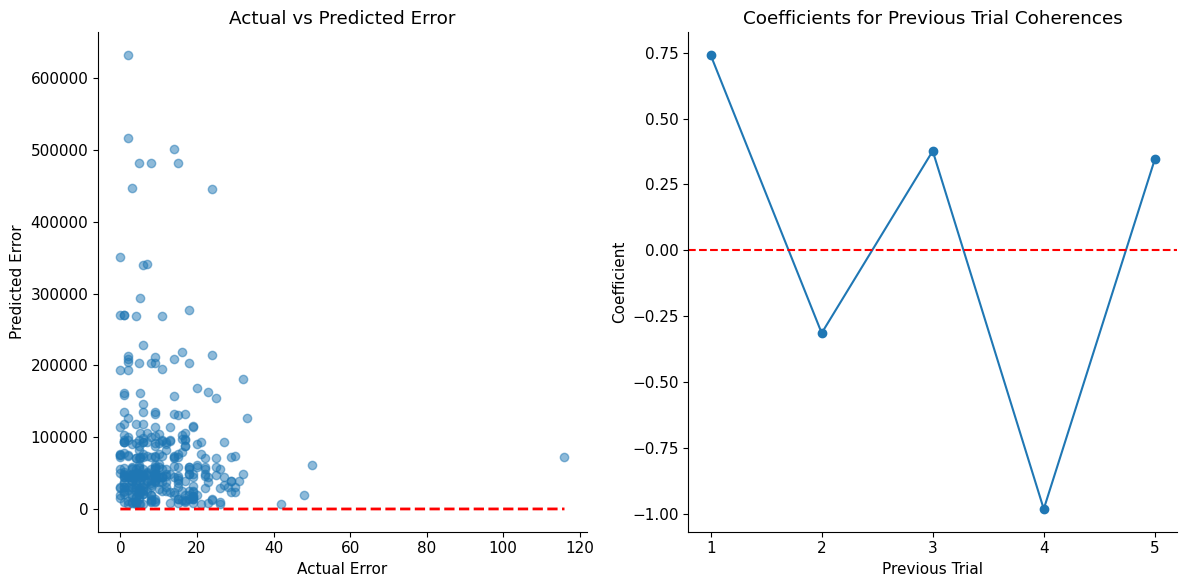

In [109]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(y_test, y_pred_poisson, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Error")
plt.ylabel("Predicted Error")
plt.title("Actual vs Predicted Error")

plt.subplot(122)
plt.plot(results.params[1:], "o-")
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Previous Trial")
plt.ylabel("Coefficient")
plt.title("Coefficients for Previous Trial Coherences")
plt.xticks(range(n_previous), range(1, n_previous + 1))

plt.tight_layout()
plt.show()

In [36]:
# Split data into training and test sets
X = data[["circular_distance"]]
y = data["error"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)
print(f"R-squared on test set: {r_squared}")

R-squared on test set: 0.013195662567021982


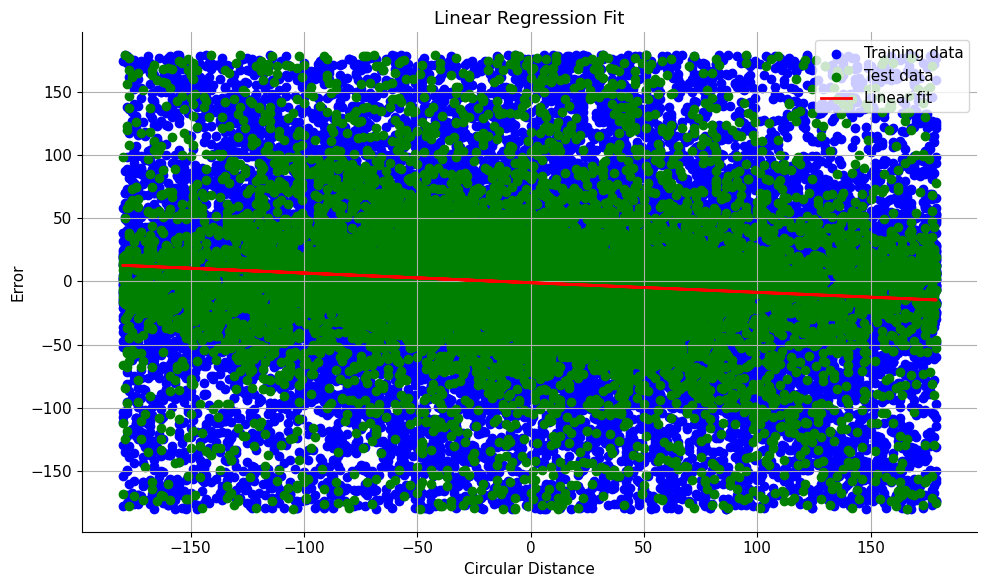

In [37]:
# Plot the training data and the fit of the model
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color="blue", label="Training data")
plt.scatter(X_test, y_test, color="green", label="Test data")
plt.plot(X_test, y_pred, color="red", linewidth=2, label="Linear fit")
plt.xlabel("Circular Distance")
plt.ylabel("Error")
plt.title("Linear Regression Fit")
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# Calculate new features
# Reaction time
# Prior_std
data["previous_error"] = data["error"].shift(1)
data["prior_difference"] = get_signed_angle(
    data["prior_mean"], data["motion_direction"], type="polar"
)

In [39]:
data = data.dropna(subset=["previous_error", "reaction_time"])

R-squared on test set: 0.0003132364414409894


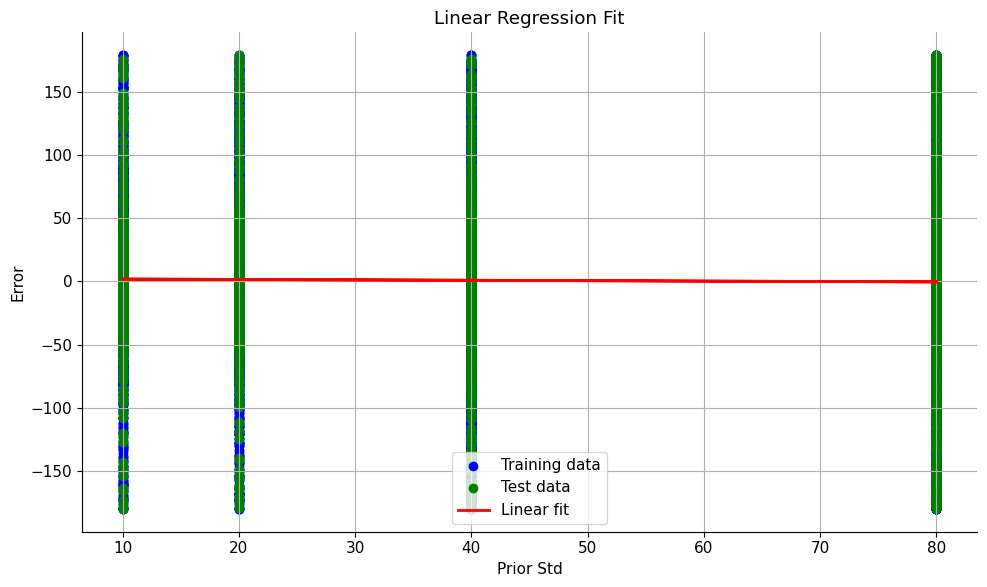

In [42]:
# Select features and target variable
features = [
    # "circular_distance",
    # "reaction_time",
    "prior_std",
    # "previous_error",
    # "prior_difference",
]
X = data[features]
y = data["error"]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R-squared value
r_squared = r2_score(y_test, y_pred)
print(f"R-squared on test set: {r_squared}")

# Plot the data and the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color="blue", label="Training data")
plt.scatter(X_test, y_test, color="green", label="Test data")
plt.plot(X_test, y_pred, color="red", linewidth=2, label="Linear fit")
plt.xlabel("Prior Std")
plt.ylabel("Error")
plt.title("Linear Regression Fit")
plt.legend()
plt.grid(True)
plt.show()